# Test different parameters systematically for sigma clipping, consecutive points in appaloosa

First, execute the following cell for different parameters, then store the results in folders accordingly, add the record to the spreadsheet. Before, execute cell below to load necessary modules.

In [40]:
import warnings
warnings.filterwarnings("ignore")
for oid in oid_list:
    RunLC_test(oid)

228682441	2018-03-05 14:20:24.015144	0	stars_shortlist/M67/hlsp_everest_k2_llc_228682441-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61103845

211410963	2018-03-05 14:20:24.498674	9	stars_shortlist/M67/hlsp_everest_k2_llc_211410963-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61102064

211411112	2018-03-05 14:20:25.113132	4	stars_shortlist/M67/hlsp_everest_k2_llc_211411112-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61102002

211416648	2018-03-05 14:20:25.617465	6	stars_shortlist/M67/hlsp_everest_k2_llc_211416648-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101947

211396422	2018-03-05 14:20:26.259151	2	stars_shortlist/M67/hlsp_everest_k2_llc_211396422-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.6110411

211412571	2018-03-05 14:20:26.808248	5	stars_shortlist/M67/hlsp_everest_k2_llc_211412571-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101854

211418561	2018-03-05 14:20:27.420136	11	stars_s

## Load all necessary modules and the list of EPIC IDs for the test sample

In [51]:
import pandas as pd
import numpy as np
import os
from appaloosa import RunLC
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
#rcParams['font.sans-serif'] = ['Tahoma']
os.chdir('/home/ekaterina/Documents/appaloosa/appaloosa')
def RunLC_test(oid):
    loc = 'stars_shortlist/M67'
    tpf_loc = 'stars_shortlist/M67/ktwo{}-c05_lpd-targ.fits.gz'.format(oid)
    lc_loc = 'stars_shortlist/M67/hlsp_everest_k2_llc_{}-c05_kepler_v2.0_lc.fits'.format(oid)
    os.chdir('/home/ekaterina/Documents/appaloosa')
    RunLC(lc_loc, dbmode='everest', display=False, debug=False, dofake=False, writeout=True)
    return

def generate_sample_bool(oid_list,tests):
    sample_bool = pd.DataFrame({'data':[0]*3800})
    for oid in oid_list:
        OID = str(oid)
        cdf = calc_compdf(oid,tests)
        #print(cdf.head())
        c = [edges_to_bool(cdf,istart='istart'+item,istop='istop'+item) for (item,l) in tests]
        columns = ['{}{}'.format(OID,item) for (item,l) in tests]
        c = pd.DataFrame(np.array(c).T, columns=columns)
       # print(c.describe())
        #print(type(c1),len(c),type(c))
        sample_bool = sample_bool.join(c)
    for (suffix,l) in tests:
        columns = [item for item in list(sample_bool.columns) if suffix in item]
        #print(columns)
        sample_bool[suffix] = sample_bool[columns].sum(axis=1)
    sample_bool.dropna(axis=0,how='all',inplace=True)

    return sample_bool

def calc_compdf(oid,tests):

    compdf = pd.DataFrame({'time':[0]*3800,'flux_gap':[0]*3800,'flux_model':[0]*3800,'istop':[0]*3800,'istart':[0]*3800})

    for (item,l) in tests:
        location = '{}/test{}/{}_flux.csv'.format(loc,item,oid)
        compdf_flux = pd.read_csv(location,usecols=['flux_gap','time','flux_model'])
        location_flares = '{}/test{}/{}_flares.csv'.format(loc,item,oid)
        compdf_flares = pd.read_csv(location_flares,usecols=['istart','istop'])
        c = compdf_flux.join(compdf_flares)
        compdf = compdf.join(c,rsuffix=item)
    compdf.drop(labels=['time','flux_gap','flux_model','istart','istop'],axis=1,inplace=True)
    compdf.dropna(axis=0, how='all',inplace=True)
    #print(compdf.tail())
    return compdf

def edges_to_bool(df,istart='istart',istop='istop'):
    rangeflare = []
    end=len(df)
    df = df[[istart,istop]]
    df = df.dropna(axis=0, how='all')
    for i,row in df.iterrows():
        rangeflare.append(list(range(int(row[istart]),int(row[istop]))))

    isflare = np.zeros(end)
    rangeflare = [item for sublist in rangeflare for item in sublist]

    np.put(isflare,rangeflare,np.ones_like(rangeflare))
    
    return isflare

def display_comparison(oid_list,tests,title,name,sample_bool):
    f = plt.figure(figsize=(12,6))
    ax = f.add_subplot(111)
    ax.set_title(title)
    for idx,(item,l) in enumerate(tests):
        ax.plot(sample_bool[item]+len(oid_list)*idx,alpha=0.5,label='{} = {}'.format(name,l))
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    f.show()
    return



## Now move to the stored tests and define the folder suffixes from where to use the results

In [42]:
os.chdir('/home/ekaterina/Documents/appaloosa')
oid_list = pd.read_csv('stars_shortlist/M67/M67_short.txt',names=['EPIC'])
oid_list = oid_list.EPIC.tolist()

loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/M67/results'

test_collection = pd.DataFrame({'title':['Number of consecutive points threshold test: (N1 = 3 sigma, N2 = 2 sigma)',
                           'Sigma clipping threshold test: (N3(consecutive points) = 3, N2 = 2 sigma)',
                           'Sigma clipping threshold test: (N3(consecutive points) = 3, N1 = 4 sigma)',
                           'Sigma clipping threshold test: (N3(consecutive points) = 3, N1 = 3 sigma)',
                           'Using corrected EVEREST LCs\nNumber of consecutive points threshold test: (N1 = 3 sigma, N2 = 2 sigma)',
                           'Corrected vs. uncorrected EVEREST LCs\n (N1 = 3 sigma, N2 = 2 sigma, N3 = 3 consecutive points)',
                           'Using corrected EVEREST LCs\nNumber of consecutive points threshold test: (N1 = 3 sigma, N2 = 2 sigma)',
                           'Using corrected EVEREST LCs\nNumber of consecutive points threshold test: (N1 = 4 sigma, N2 = 2 sigma)',
                           'Using corrected EVEREST LCs\nNumber of consecutive points threshold test: (N1 = 4 sigma, N2 = 2 sigma)',
                           ],
                  'tests': [[('_01','3 points'),('_02','4 points'),('_03','5 points')],
                           [('_06','2 sigma'),('_01','3 sigma'),('_04','4 sigma')],
                           [('_04','2 sigma'),('_07','1 sigma'),('_08','0 sigma')],
                           [('_01','2 sigma'),('_09','1 sigma'),('_10','0 sigma')],
                           [('_11','3 points'),('_12','4 points'),('_13','5 points')],
                           [('_01','uncorrected'),('_11','corrected')],
                           [('_13','5 points'),('_14','6 points'),('_15','7 points')],
                           [('_16','3 points'),('_17','4 points'),('_18','5 points')],
                           [('_18','5 points'),('_19','6 points'),('_20','7 points')],
                           ],
                  'name':['N3','N1','N2','N2','N3','EVEREST','N3','N3','N3']})

pd.set_option('max_colwidth',400)
print(test_collection)

      name                                                tests  \
0       N3  [(_01, 3 points), (_02, 4 points), (_03, 5 points)]   
1       N1     [(_06, 2 sigma), (_01, 3 sigma), (_04, 4 sigma)]   
2       N2     [(_04, 2 sigma), (_07, 1 sigma), (_08, 0 sigma)]   
3       N2     [(_01, 2 sigma), (_09, 1 sigma), (_10, 0 sigma)]   
4       N3  [(_11, 3 points), (_12, 4 points), (_13, 5 points)]   
5  EVEREST               [(_01, uncorrected), (_11, corrected)]   
6       N3  [(_13, 5 points), (_14, 6 points), (_15, 7 points)]   
7       N3  [(_16, 3 points), (_17, 4 points), (_18, 5 points)]   
8       N3  [(_18, 5 points), (_19, 6 points), (_20, 7 points)]   

                                                                                                    title  
0                               Number of consecutive points threshold test: (N1 = 3 sigma, N2 = 2 sigma)  
1                               Sigma clipping threshold test: (N3(consecutive points) = 3, N2 = 2 sigma)  
2    

In [43]:
title, tests, name = test_collection.iloc[6][['title','tests','name']]
tests

[('_13', '5 points'), ('_14', '6 points'), ('_15', '7 points')]

## Before doing the big analysis, explore the differences between the results for a single light curve

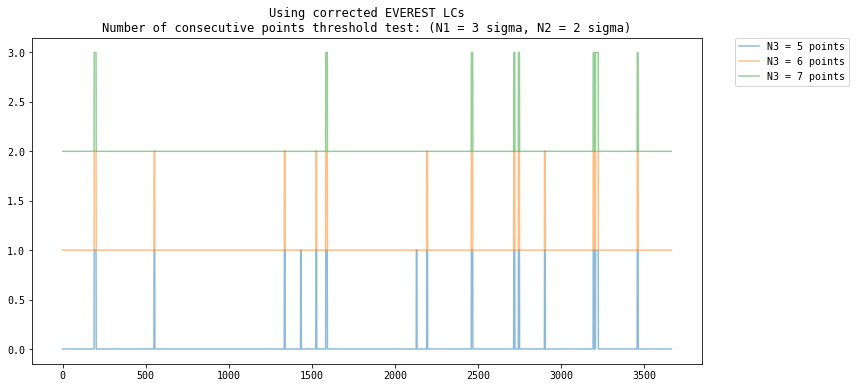

In [44]:
compdf = calc_compdf(oid_list[3],tests)

for (item,l) in tests:
    compdf['isflare'+item] = edges_to_bool(compdf,istart='istart'+item,istop='istop'+item)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.set_title(title)
i = 0
for (item,l) in tests:
    ax.plot(compdf['isflare'+item]+i,alpha=0.5,label='{} = {}'.format(name,l))
    i+=1
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.show()

## If the exploration above looks sensible, do the same for all light curves in the test sample added together

In [45]:
sample_bool = generate_sample_bool(oid_list,tests)

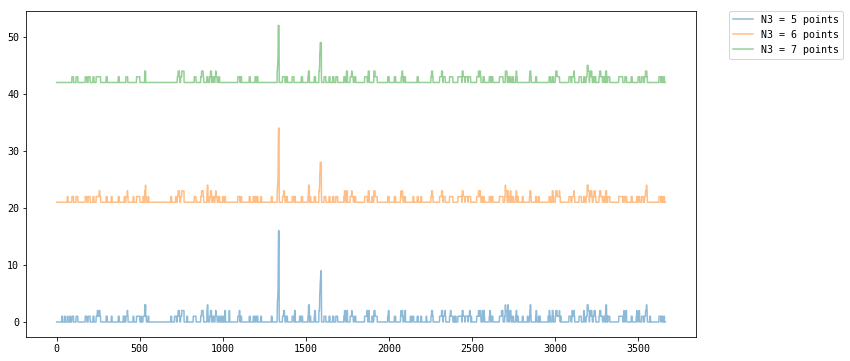

In [46]:
display_comparison(oid_list,tests,title,name,sample_bool)

## Comparing various things

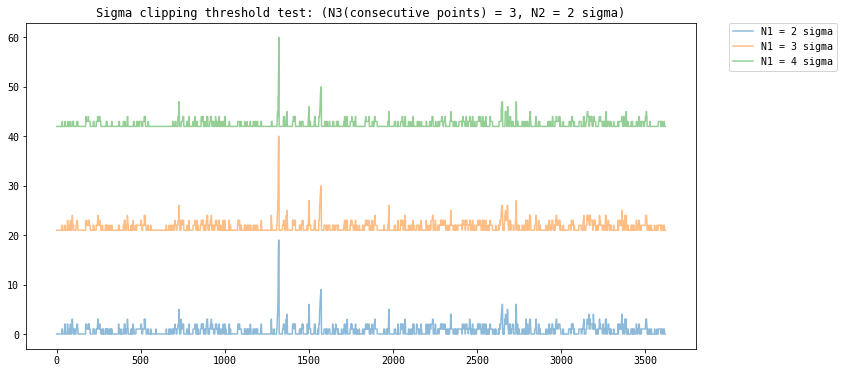

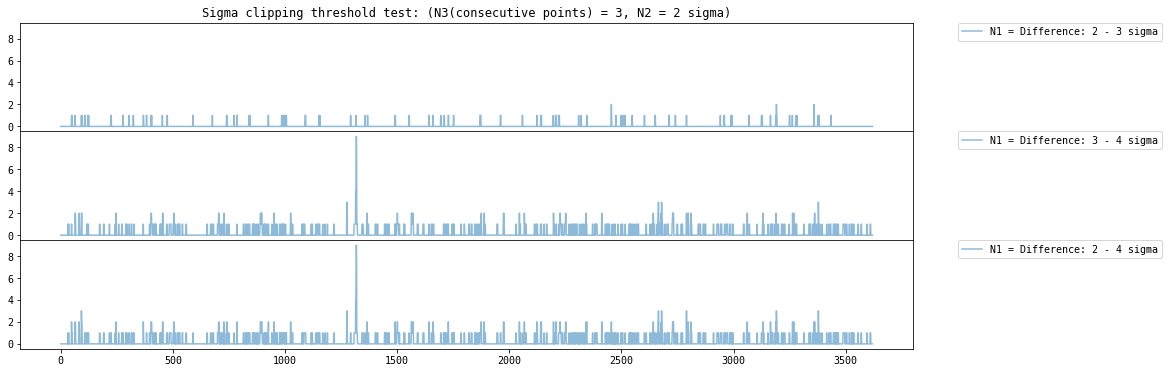

In [57]:
title, tests, name = test_collection.iloc[1][['title','tests','name']]
sample_bool = generate_sample_bool(oid_list,tests)
display_comparison(oid_list,tests,title,name,sample_bool)

p, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True,figsize=(16,6))
ax1.set_title(title)
ax1.plot(sample_bool['_06']-sample_bool['_01'],alpha=0.5,label='{} = Difference: 2 - 3 sigma'.format(name))
ax3.plot(sample_bool['_06']-sample_bool['_04'],alpha=0.5,label='{} = Difference: 2 - 4 sigma'.format(name))
ax2.plot(sample_bool['_01']-sample_bool['_04'],alpha=0.5,label='{} = Difference: 3 - 4 sigma'.format(name))
# Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
p.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in p.axes[:-1]], visible=False)

ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p.show()

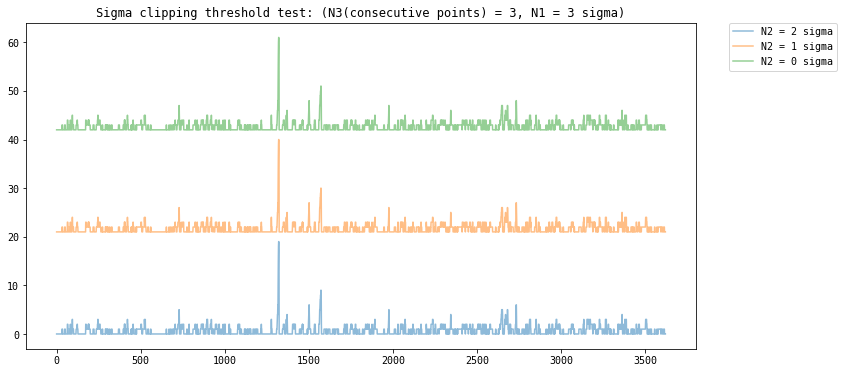

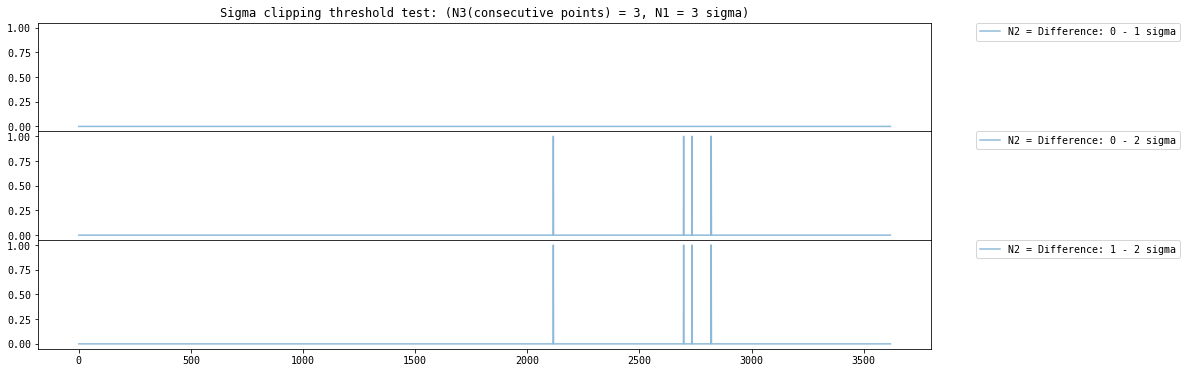

In [56]:
title, tests, name = test_collection.iloc[3][['title','tests','name']]
sample_bool = generate_sample_bool(oid_list,tests)
display_comparison(oid_list,tests,title,name,sample_bool)


p, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True,figsize=(16,6))
ax1.set_title(title)
ax1.plot(sample_bool['_10']-sample_bool['_09'],alpha=0.5,label='{} = Difference: 0 - 1 sigma'.format(name))
ax3.plot(sample_bool['_09']-sample_bool['_01'],alpha=0.5,label='{} = Difference: 1 - 2 sigma'.format(name))
ax2.plot(sample_bool['_10']-sample_bool['_01'],alpha=0.5,label='{} = Difference: 0 - 2 sigma'.format(name))
# Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
p.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in p.axes[:-1]], visible=False)

ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p.show()

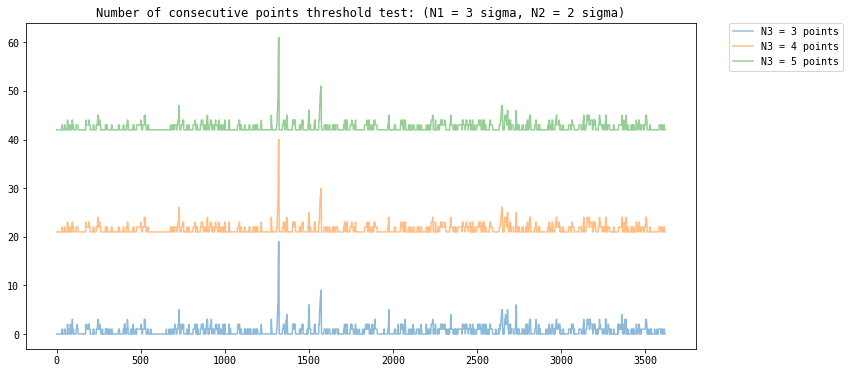

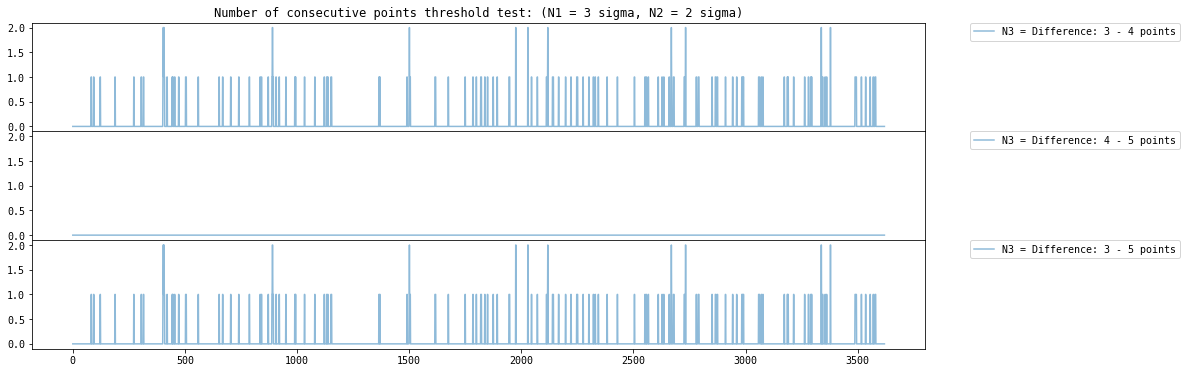

In [55]:
title, tests, name = test_collection.iloc[0][['title','tests','name']]
sample_bool = generate_sample_bool(oid_list,tests)
display_comparison(oid_list,tests,title,name,sample_bool)

p, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True,figsize=(16,6))
ax1.set_title(title)
ax1.plot(sample_bool['_01']-sample_bool['_02'],alpha=0.5,label='{} = Difference: 3 - 4 points'.format(name))
ax2.plot(sample_bool['_02']-sample_bool['_03'],alpha=0.5,label='{} = Difference: 4 - 5 points'.format(name))
ax3.plot(sample_bool['_01']-sample_bool['_03'],alpha=0.5,label='{} = Difference: 3 - 5 points'.format(name))
# Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
p.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in p.axes[:-1]], visible=False)

ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p.show()

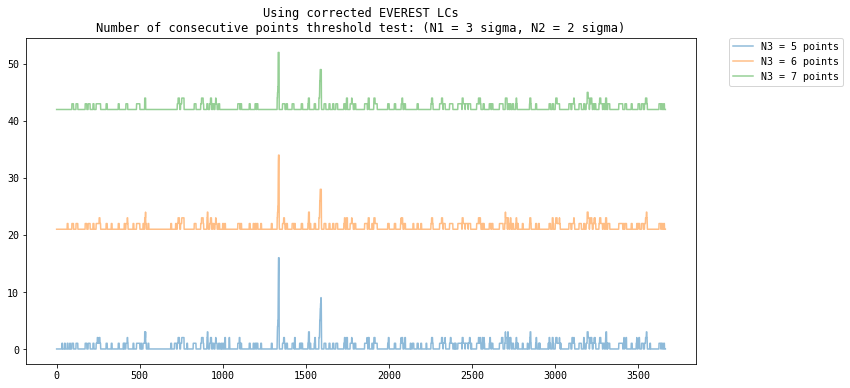

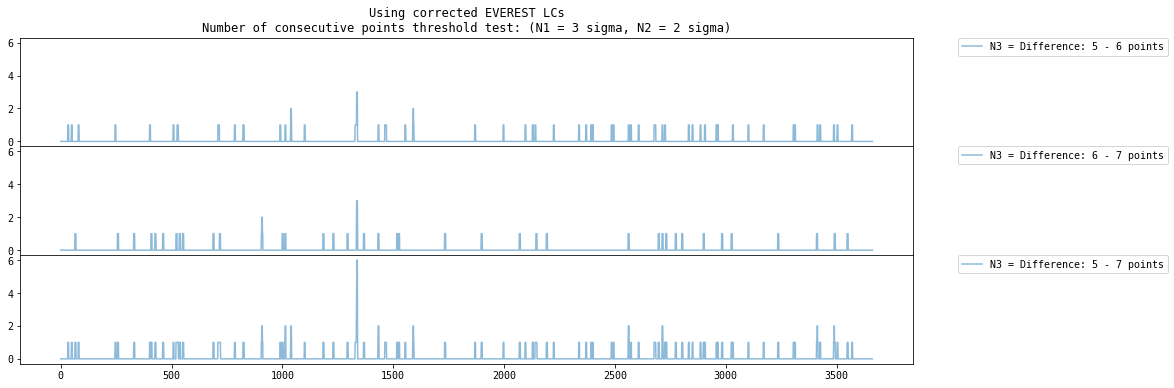

In [52]:
title, tests, name = test_collection.iloc[6][['title','tests','name']]
sample_bool = generate_sample_bool(oid_list,tests)
display_comparison(oid_list,tests,title,name,sample_bool)

p, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True,figsize=(16,6))
ax1.set_title(title)
ax1.plot(sample_bool['_13']-sample_bool['_14'],alpha=0.5,label='{} = Difference: 5 - 6 points'.format(name))
ax2.plot(sample_bool['_14']-sample_bool['_15'],alpha=0.5,label='{} = Difference: 6 - 7 points'.format(name))
ax3.plot(sample_bool['_13']-sample_bool['_15'],alpha=0.5,label='{} = Difference: 5 - 7 points'.format(name))
# Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
p.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in p.axes[:-1]], visible=False)
#plt.tight_layout()
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p.show()


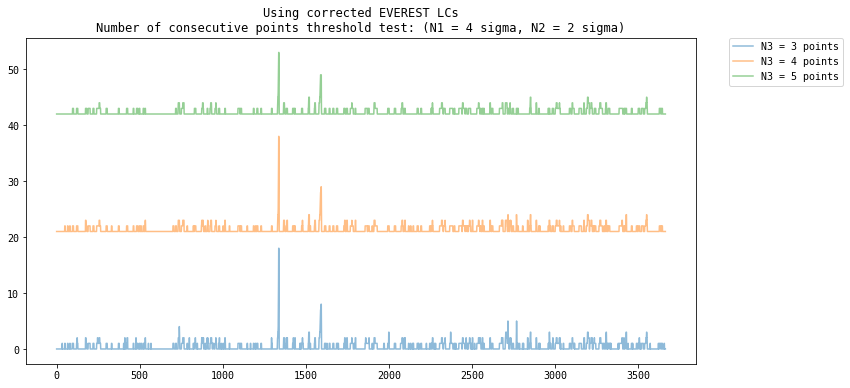

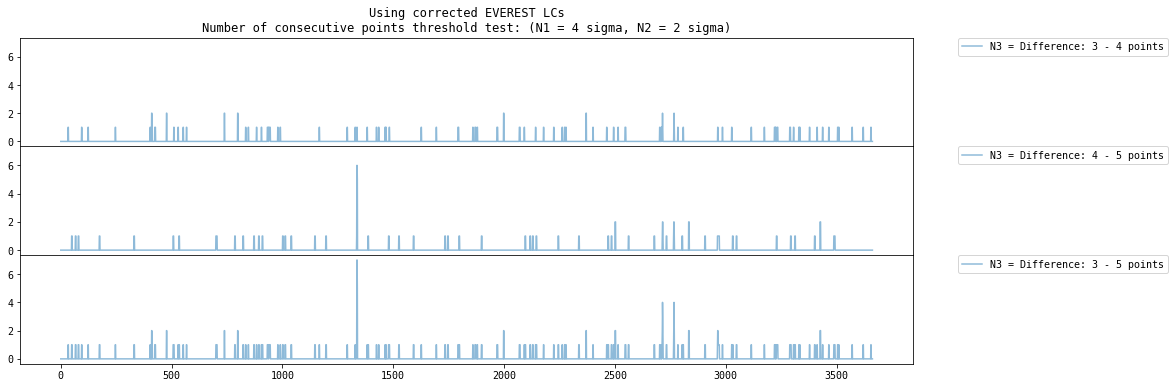

In [53]:
title, tests, name = test_collection.iloc[7][['title','tests','name']]
sample_bool = generate_sample_bool(oid_list,tests)
display_comparison(oid_list,tests,title,name,sample_bool)

p, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True,figsize=(16,6))
ax1.set_title(title)
ax1.plot(sample_bool['_16']-sample_bool['_17'],alpha=0.5,label='{} = Difference: 3 - 4 points'.format(name))
ax2.plot(sample_bool['_17']-sample_bool['_18'],alpha=0.5,label='{} = Difference: 4 - 5 points'.format(name))
ax3.plot(sample_bool['_16']-sample_bool['_18'],alpha=0.5,label='{} = Difference: 3 - 5 points'.format(name))
# Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
p.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in p.axes[:-1]], visible=False)
#plt.tight_layout()
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p.show()

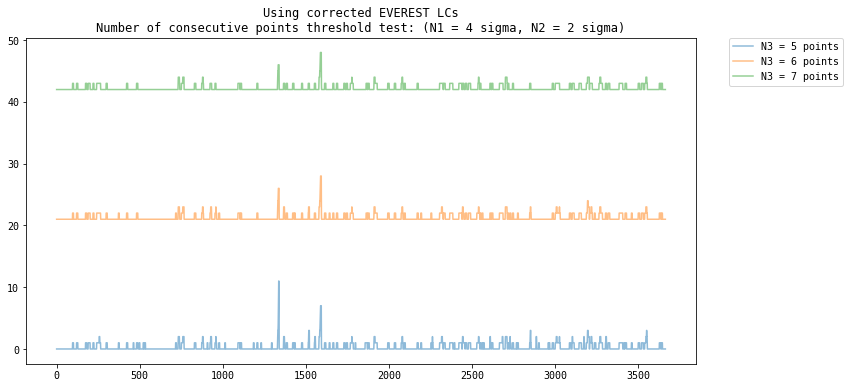

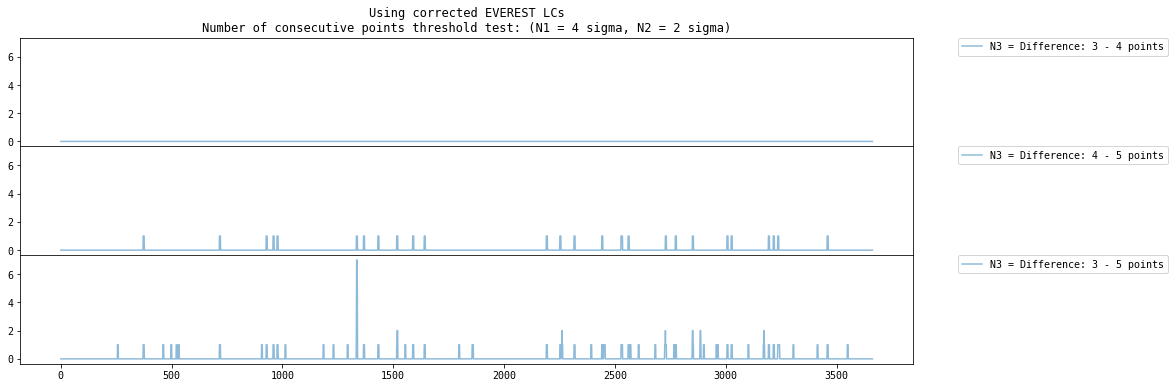

In [54]:
title, tests, name = test_collection.iloc[8][['title','tests','name']]
sample_bool = generate_sample_bool(oid_list,tests)
display_comparison(oid_list,tests,title,name,sample_bool)

p, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True,figsize=(16,6))
ax1.set_title(title)
ax1.plot(sample_bool['_18']-sample_bool['_18'],alpha=0.5,label='{} = Difference: 3 - 4 points'.format(name))
ax2.plot(sample_bool['_19']-sample_bool['_20'],alpha=0.5,label='{} = Difference: 4 - 5 points'.format(name))
ax3.plot(sample_bool['_18']-sample_bool['_20'],alpha=0.5,label='{} = Difference: 3 - 5 points'.format(name))
# Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
p.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in p.axes[:-1]], visible=False)
#plt.tight_layout()
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p.show()